In [11]:
import os, time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from the_well.data import WellDataset
# !pip install the_well[benchmark]

import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange
from neuralop.models import FNO
from tqdm import tqdm

from the_well.benchmark.metrics import VRMSE
from the_well.data import WellDataset
from the_well.utils.download import well_download

import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


# ------------------------------------------------------------
# 0) Device setup
# ------------------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("high")

print(f"✅ Device: {torch.cuda.get_device_name(0)}")

# ------------------------------------------------------------

# 1) Load dataset
# ------------------------------------------------------------
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=81,
    n_steps_output=0,
    use_normalization=True,

)

✅ Device: NVIDIA GeForce RTX 4060 Ti


/home/itachi/miniconda3/envs/ml/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch
# from einops import rearrange
# from neuralop.models import FNO
# from tqdm import tqdm

# from the_well.benchmark.metrics import VRMSE
# from the_well.data import WellDataset
# from the_well.utils.download import well_download

# well_base_path="/home/itachi/Desktop/msc/data/datasets"
# well_download(base_path=well_base_path, dataset="active_matter", split="valid")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1354 100  1354   0     0  2385     0  --:--:-- --:--:-- --:--:--  2388
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0   0     0   0     0     0     0  --:--:-- --:--:-- --:--:--     0

100 222.7M 100 222.7M   0     0 34114k     0   0:00:06  0:00:06 --:--:-- 41045k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 222.7M 100 222.7M   0     0 22343k     0   0:00:10  0:00:10 --:--:-- 29805k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 445.5M 100 445.5M   0     0 31608k     0   0:00:14  0:00:14 --:--:-- 34792k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 445.5M 100 445.5M   0     0 40205k     0   0:00:11  0:00:11 --:--:-- 41137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 445.5M 100 445.5M   0     0 28479k     0   0

##Exploratory analysis


In [78]:
len(dataset)

175

In [79]:
dataset.metadata.field_names

{0: ['concentration'],
 1: ['velocity_x', 'velocity_y'],
 2: ['D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']}

In [3]:
item = dataset[0]
print(item.keys())
print(item['input_fields'].shape)




dict_keys(['input_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid'])
torch.Size([81, 256, 256, 11])


In [4]:
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)



DIVISION TRAN/TEST DATA

In [5]:
print(train_idx.shape, test_idx.shape)

(140,) (35,)


TRAIN DATA

In [6]:
print(train_idx)

[118 143 164  38 135 104  67 148   2  98 152 159  75 108  26 161  90 115
  69  36  85  22 144  96  68 168  11  97  76   6  27  82   4  32  93 120
 166  10 171 122   0 132 124  64  44  95  28  40 125  25  23 142  81  79
  84  39 100  86 119 170 147  47  94 133 163  61  73  33 123 136 137  62
 173 111 114 105  53   5 157   3 162  49  35  80  77  34  46   7  43  70
 140 110  91  83 154 158  89   8  13  59 150 131  17  72 153 134 146 160
  63  54 107  50 172  58  48  88  21  57 169 129  37 165   1  52 149 130
 151 103  99 116  87  74 121 174  20  71 106  14  92 102]


EXPLORATORY DATA

torch.Size([81, 256, 256, 11])


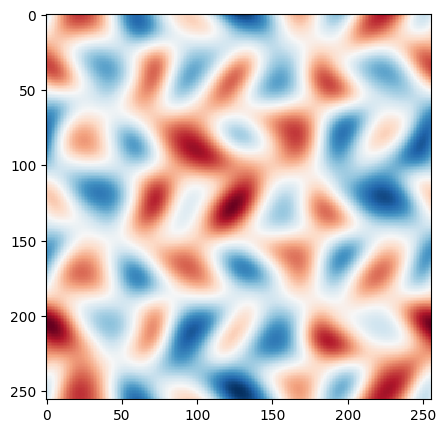

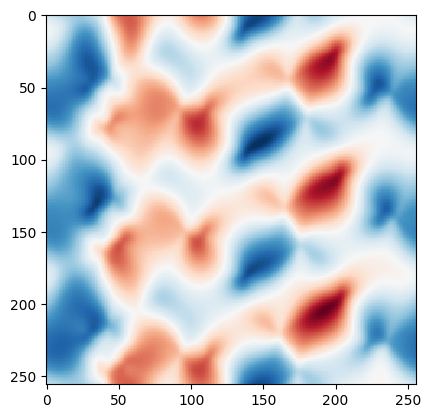

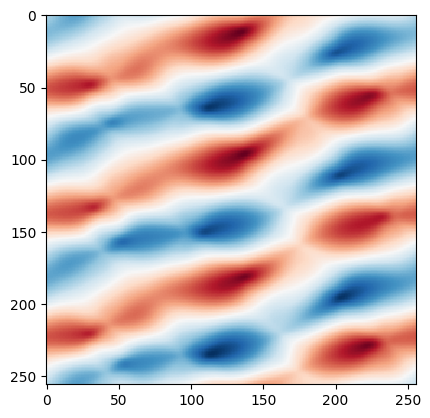

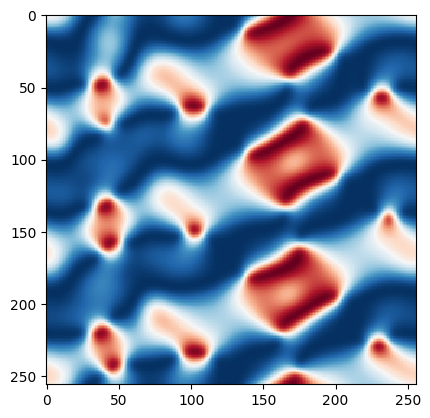

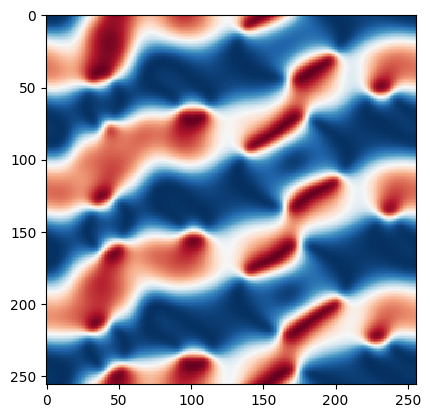

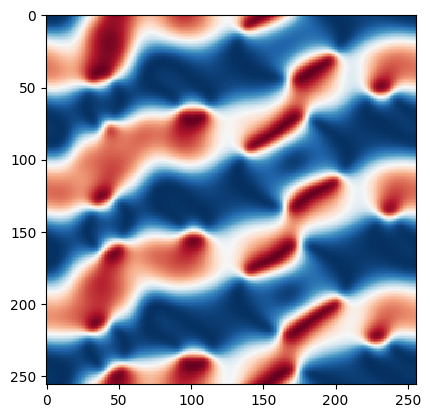

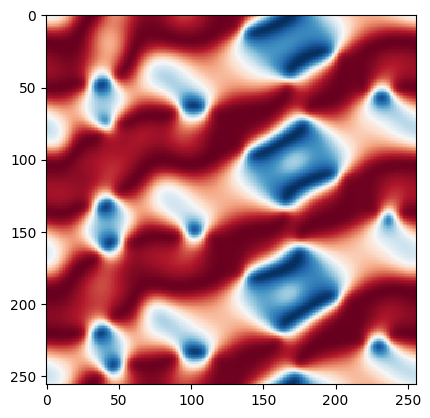

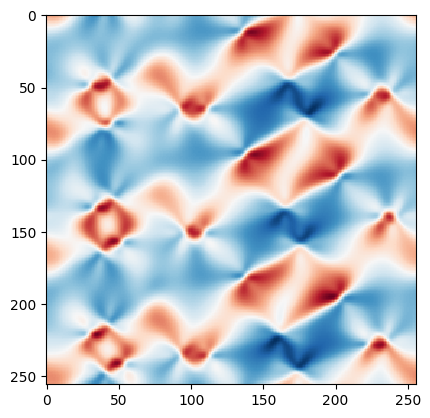

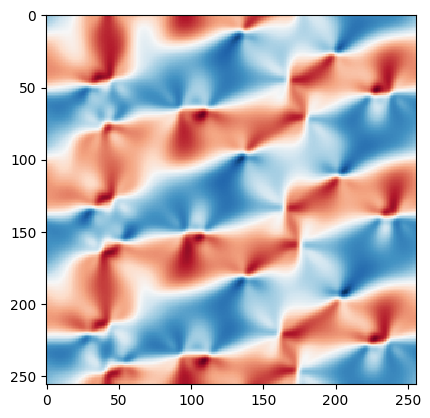

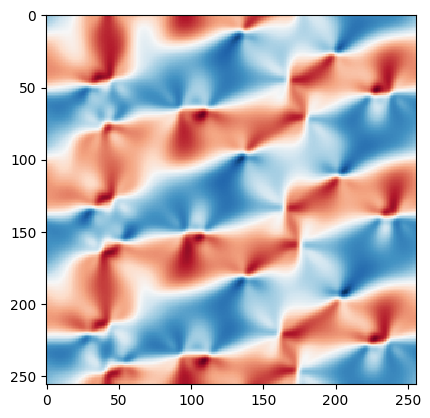

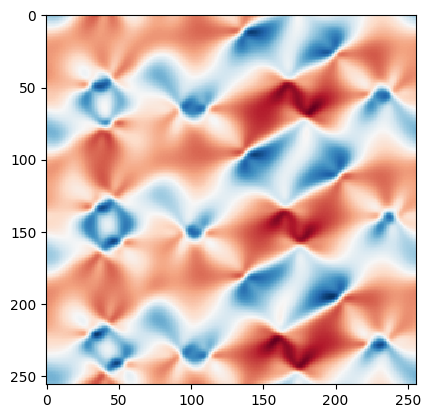

In [7]:


x = dataset[train_idx[0]]['input_fields']
print(x.shape)
T, Lx, Ly, F = x.shape
ti = 10

plt.figure(figsize=(15, 5))
for i in range(11):
    img = x[ti,:,:, i] 
    vmin = np.nanmin(img)
    vmax = np.nanmax(img)
    plt.imshow(img,cmap="RdBu_r",interpolation="none",vmin=vmin,vmax=vmax)
    plt.show()

FEATURE CALCULATION

In [11]:


N = len(train_idx)
T = 81

mc = np.zeros((N, T), dtype=np.float32)
Ke = np.zeros((N, T), dtype=np.float32)
S = np.zeros((N, T), dtype=np.float32)
Srm = np.zeros((N, T), dtype=np.float32)
N_o = np.zeros((N, T), dtype=np.float32)
C_c = np.zeros((N, T), dtype=np.float32)

for i in range(N):

    item = dataset[train_idx[i]]
    x    = item['input_fields']  

    for t in range(T):
        c  = x[t, :, :, 0].mean()

        vx = x[t, :, :, 1]
        vy = x[t, :, :, 2]
        ke = 0.5 * ( (vx**2 + vy**2).mean() )

        dxx = x[t, :, :, 3]
        dxy = x[t, :, :, 4]
        dyx = x[t, :, :, 5]
        dyy = x[t, :, :, 6]
        Si = ((dxx*vy - dyy*vx)**2).mean()

        Exx = x[t, :, :, 7]
        Exy = x[t, :, :, 8]
        Eyx = x[t, :, :, 9]
        Eyy = x[t, :, :, 10]
        smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
        no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()

        cc = (vx*dxx + vy*dyx).mean()

        mc[i, t] = c
        Ke[i, t] = ke
        S[i,t] = Si
        Srm[i,t] = smr
        N_o[i,t] = no
        C_c[i,t] = cc

/tmp/ipykernel_7269/602541751.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  smr = np.sqrt(Exx**2 + 2*Exy*Eyx + Eyy**2).mean()
/tmp/ipykernel_7269/602541751.py:34: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  no = np.sqrt(dxx**2 + dxy**2 + dyx**2 + dyy**2).mean()


HISTOGRAM FOR EACH FEATURE ACRROS THE NUMBER OF SIMULATIONS:
we need to choose the time 

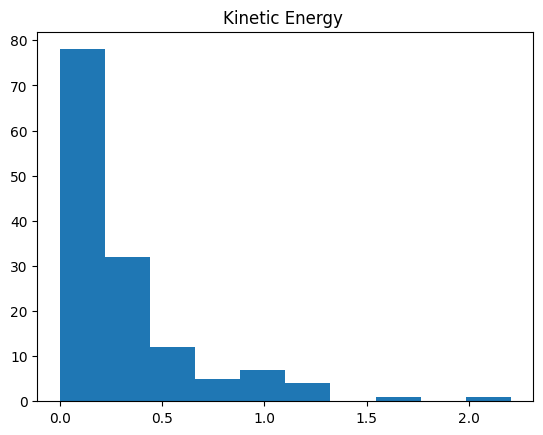

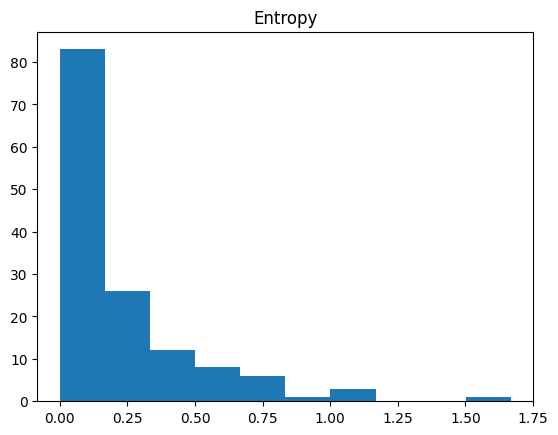

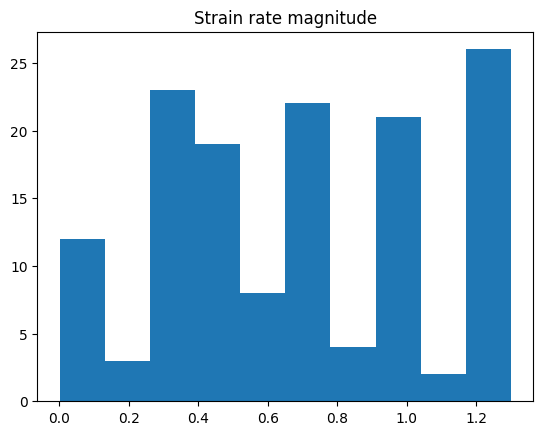

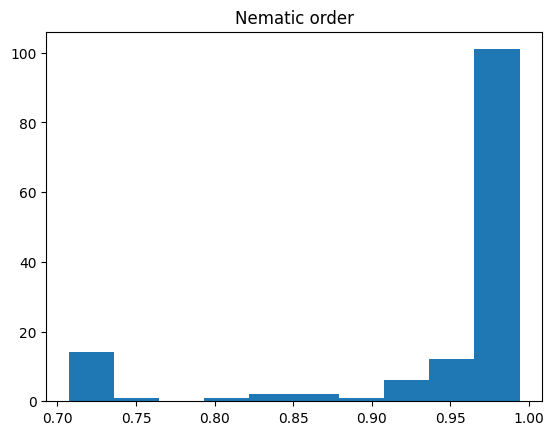

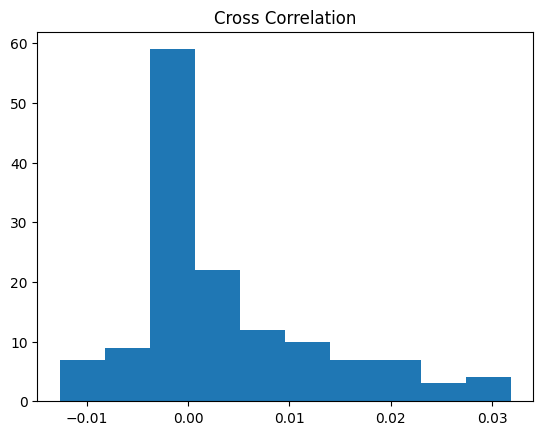

In [52]:
T = 8 #choose the time step to plot
# plt.hist(mc[:,T])
# plt.title('Concentration')
# plt.show()
plt.hist(Ke[:,T])
plt.title('Kinetic Energy ')
plt.show()
plt.hist(S[:,T])
plt.title('Entropy') 
plt.show()
plt.hist(Srm[:,T])
plt.title('Strain rate magnitude')
plt.show()
plt.hist(N_o[:,T])
plt.title('Nematic order') 
plt.show()
plt.hist(C_c[:,T])
plt.title('Cross Correlation')
plt.show()




In [40]:
print(Ke.shape)
print(S[1,1])

(140, 81)
0.0001255089


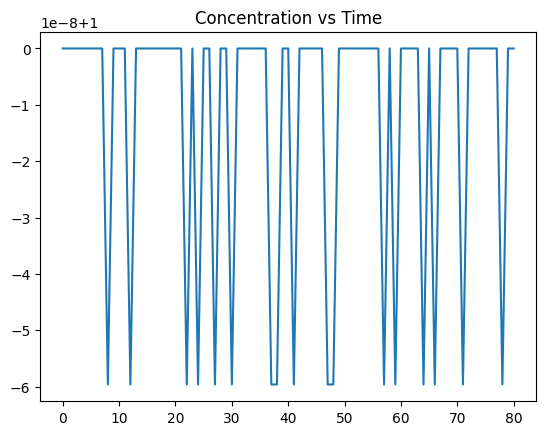

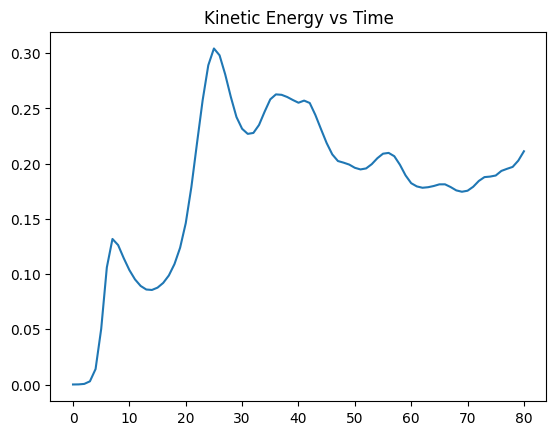

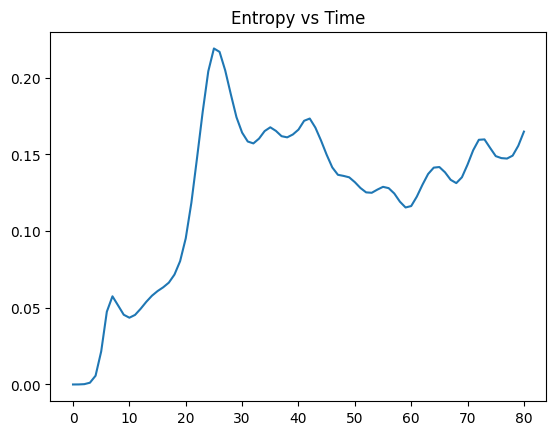

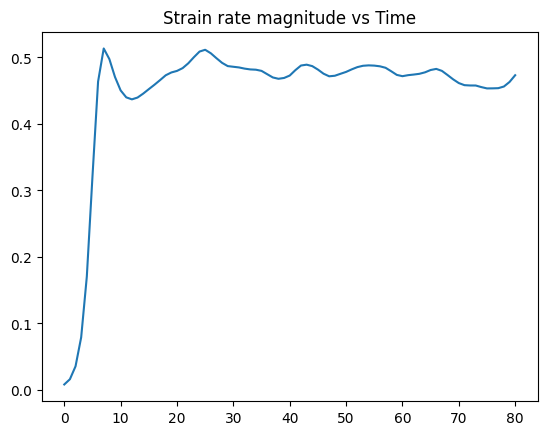

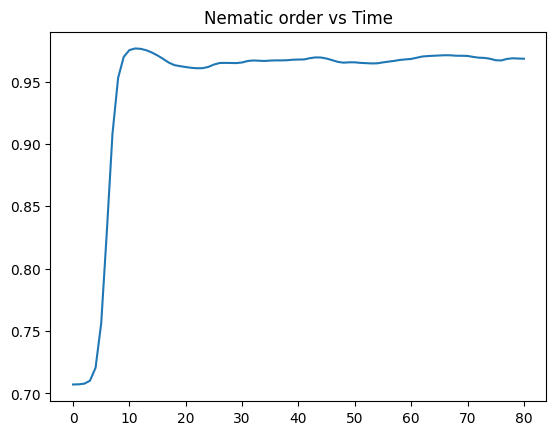

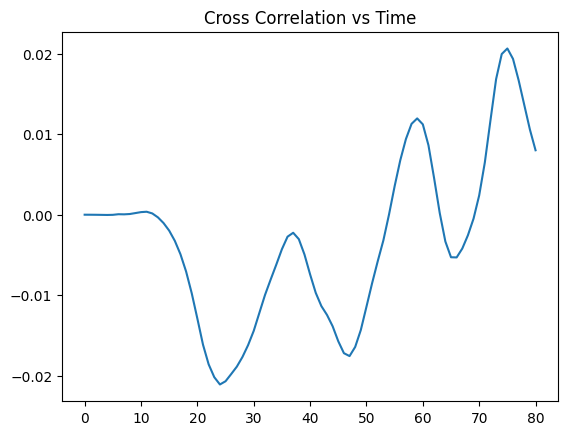

In [51]:

sim_num = 139
T = np.linspace(0,80,81,dtype=int)
cm_val = mc[sim_num,T]
ke_val = Ke[sim_num,T]    
s_val = S[sim_num,T]
srm_val = Srm[sim_num,T]
no_val = N_o[sim_num,T]
cc_val = C_c[sim_num,T]

plt.plot(T, cm_val)
plt.title('Concentration vs Time')
plt.show()
plt.plot(T, ke_val)
plt.title('Kinetic Energy vs Time')
plt.show()
plt.plot(T, s_val)
plt.title('Entropy vs Time')    
plt.show()
plt.plot(T, srm_val)
plt.title('Strain rate magnitude vs Time')
plt.show()
plt.plot(T, no_val)
plt.title('Nematic order vs Time')                
plt.show()
plt.plot(T, cc_val)
plt.title('Cross Correlation vs Time')
plt.show()


AUTOENCODER

In [10]:
print(len(dataset))
item = dataset[0]
print(item['input_fields'].shape)  


14175
torch.Size([1, 256, 256, 11])


In [31]:
idx = np.arange(len(dataset))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, shuffle=True)
print(train_idx)
print(test_idx)

[4096 1219 5076 ... 5390  860 7270]
[ 2315  9096  5169 ...  1830 13854    85]


AUTOENCODER


In [1]:
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models


In [2]:
# encoder_input = keras.Input(shape=(1, 256, 256, 11), name = 'img11')
# x = keras.layers.Flatten()(encoder_input)
# encoder_output = keras.layers.Dense(128, activation='relu')(x)

# encoder = keras.Model(encoder_input, encoder_output, name='encoder')

# decoder_input = keras.layers.Dense(720896, activation='relu')(encoder_output)
# decoder_output = keras.layers.Reshape((1, 256, 256, 11))(decoder_input)

# opt = keras.optimizers.Adam(learning_rate=1e-3, decay = 1e-5)

# autoencoder = keras.Model(encoder_input, decoder_output, name='autoencoder')
# autoencoder.summary()

In [ ]:
# autoencoder.compile(optimizer=opt, loss='mse')

In [3]:
# autoencoder.fit(dataset[]['input_fields'], dataset[]['input_fields'], epochs=50, batch_size=32, validation_split=0.2)

In [8]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

Step 2: Loading the Dataset

Now we will load images, each sized 256x256x11 pixels. We will convert images to tensors.

In [ ]:
tensor_transform = transforms.ToTensor()

#dataset = datasets.MNIST(root="./data", train=True,download=True, transform=tensor_transform)
dataset = WellDataset(
    well_base_path="/home/itachi/Desktop/msc/data/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=1,
    n_steps_output=0,
    use_normalization=True,
)

loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)



In [16]:
dataset[0]['input_fields'].shape

torch.Size([1, 256, 256, 11])

Step 3: Define the Autoencoder Model

In this step we are going to define our autoencoder. It consists of two components:

Encoder: Compresses the 784-pixel image into a smaller latent representation through fully connected layers with ReLU activations helps in reducing dimensions.

256*256*11 = 720896 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9


Decoder: Reconstructs the original image by expanding the latent vector back to the original size, ending with a Sigmoid activation to output pixel values between 0 and 1

9 ==> 18 ==> 36 ==> 64 ==> 128 ==> 720896 ==> 256*256*11 = 720896

In [18]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.flat_dim = 1 * 256 * 256 * 11  # T*H*W*C
        self.encoder = nn.Sequential(
            nn.Flatten(),                          # (B, 1,256,256,11) -> (B, 720896)
            nn.Linear(self.flat_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),                      # latente de 9
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.flat_dim),
            nn.Sigmoid(),                          # Usa Sigmoid SOLO si tus inputs están en [0,1]
            nn.Unflatten(1, (1, 256, 256, 11))     # back to (B, 1,256,256,11)
        )

    def forward(self, x):   # x: (B, 1,256,256,11)
        z = self.encoder(x)
        xr = self.decoder(z)
        return xr, z

Step 4: Initializing Model

After defining the autoencoder, we create an instance of the model. We use Mean Squared Error (MSE) as the loss function since it measures how close the reconstructed images are to the original inputs. For optimization, we use the Adam optimizer with a learning rate of 0.001 and weight decay of 10e-8 which helps to prevent overfitting.

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

Step 5: Training the model and Plotting Training Loss

In this step the model undergoes training for 20 epochs. The training process updates the model's weights using backpropagation and optimization techniques. Loss values are recorded during each iteration and after training a loss plot is generated to assess the model’s performance over time.

for batch in loader
Lee los datos por lotes
model(x)
Calcula la reconstrucción
loss = MSE(xr, x)
Mide el error de reconstrucción
loss.backward()
Calcula gradientes
optimizer.step()
Actualiza pesos
running += loss.item()
Acumula el error
epoch_loss = running / len(loader)
Promedia el error del epoch
losses.append(epoch_loss)
Guarda para graficar
plt.plot(losses)
Muestra la convergencia


Epoch 1/20 | Loss: 0.165231
Epoch 2/20 | Loss: 0.155389
Epoch 3/20 | Loss: 0.152813
Epoch 4/20 | Loss: 0.149818
Epoch 5/20 | Loss: 0.146902
Epoch 6/20 | Loss: 0.144242
Epoch 7/20 | Loss: 0.142530
Epoch 8/20 | Loss: 0.141486
Epoch 9/20 | Loss: 0.140624
Epoch 10/20 | Loss: 0.139862
Epoch 11/20 | Loss: 0.139235
Epoch 12/20 | Loss: 0.138784
Epoch 13/20 | Loss: 0.138327
Epoch 14/20 | Loss: 0.137930
Epoch 15/20 | Loss: 0.137441
Epoch 16/20 | Loss: 0.136970
Epoch 17/20 | Loss: 0.136442
Epoch 18/20 | Loss: 0.135869
Epoch 19/20 | Loss: 0.135414
Epoch 20/20 | Loss: 0.134628


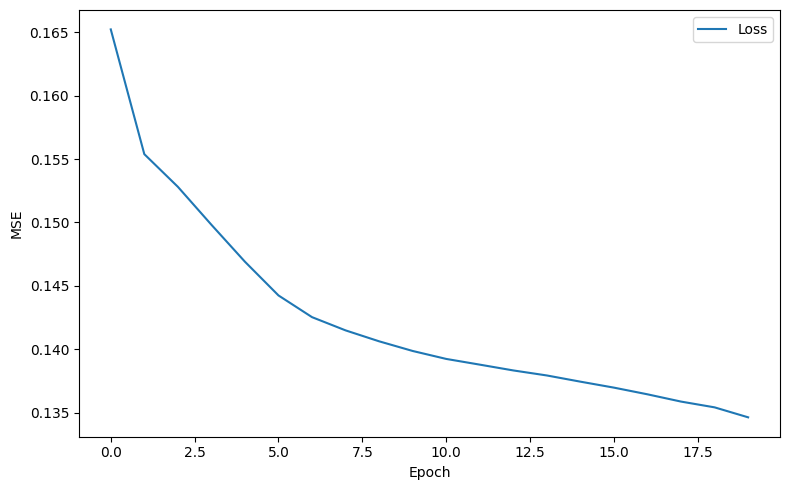

In [20]:
epochs = 20 #epochs = 20 → número de veces que todo el dataset se pasará por la red (20 iteraciones completas).
losses = [] #losses = [] → lista vacía donde iremos guardando la pérdida promedio de cada epoch para luego graficarla.

model.train() #Cambia el modelo a modo entrenamiento (activa dropout, batchnorm, etc., aunque aquí no se usan).
for epoch in range(epochs):
    running = 0.0
    for batch in loader: 	#loader entrega batches (grupos de muestras) de tamaño 32 (o el que definiste en DataLoader).
        # batch es un diccionario; tomamos solo los campos de entrada
        x = batch["input_fields"].to(device)           # (B, 1,256,256,11) #	•	Cada batch es un diccionario que incluye varios campos (input_fields, constant_scalars, etc.).
	#•	Solo tomamos input_fields, que es el tensor con las imágenes o campos físicos.
	#•	.to(device) lo mueve a GPU o CPU, según esté disponible.

        # AE lineal trabaja con el tensor tal cual porque el Flatten está en el modelo
        xr, z = model(x)                                # reconstrucción y latente
	# •	x pasa por el encoder → decoder.
	# •	xr = reconstrucción del input (salida del decoder).
	# •	z = vector latente (salida del encoder).


        loss = criterion(xr, x)
    #•	Compara la salida reconstruida (xr) con la entrada original (x).

        
        optimizer.zero_grad(set_to_none=True) # zero_grad() → limpia los gradientes acumulados del paso anterior. 
        loss.backward() #loss.backward() → calcula los gradientes de todos los parámetros del modelo (derivadas parciales del loss).
        optimizer.step() #optimizer.step() → actualiza los pesos del modelo usando Adam, siguiendo esos gradientes.

        running += loss.item()
    # •	loss.item() convierte el valor del tensor a número flotante de Python.
	# •	Se acumula para luego sacar la pérdida promedio del epoch

    epoch_loss = running / len(loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss:.6f}")

    # •	Calcula el promedio de la pérdida de todos los batches.
	# •	Lo guarda en losses (para graficar después).
	# •	Imprime el progreso con 6 decimales.

# -----------------------------------
# 4) Curva de pérdida
# -----------------------------------
plt.figure(figsize=(8,5))
plt.plot(losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# -----------------------------------
# 5) Guardar el modelo entrenado
# -----------------------------------
torch.save(model.state_dict(), "autoencoder_active_matter.pth")
print("✅ Modelo guardado como 'autoencoder_active_matter.pth'")

✅ Modelo guardado como 'autoencoder_active_matter.pth'


In [ ]:
model = AE()
model.load_state_dict(torch.load("autoencoder_active_matter.pth"))
model.to(device)
model.eval()

In [24]:
# import torch
# import numpy as np

# model.eval()  # modo evaluación (desactiva dropout, etc.)
# Z = []        # lista donde guardaremos todos los vectores latentes

# with torch.no_grad():  # sin gradientes = más rápido y menos memoria
#     for batch in loader:
#         x = batch["input_fields"].to(device)   # (B, 1,256,256,11)
#         _, z = model(x)                        # obtenemos la salida latente
#         Z.append(z.detach().cpu().numpy())     # pasamos a numpy y CPU

# # concatenar todos los lotes
# Z = np.concatenate(Z, axis=0)  # (N, 9)
# print("Espacio latente total:", Z.shape)

# # guardar a disco
# np.save("latent_space.npy", Z)
# print("Espacio latente guardado en latent_space.npy")

Latent matrix Z shape: (14175, 9)
Explained variance ratio (2D): [0.3552971  0.23620234]


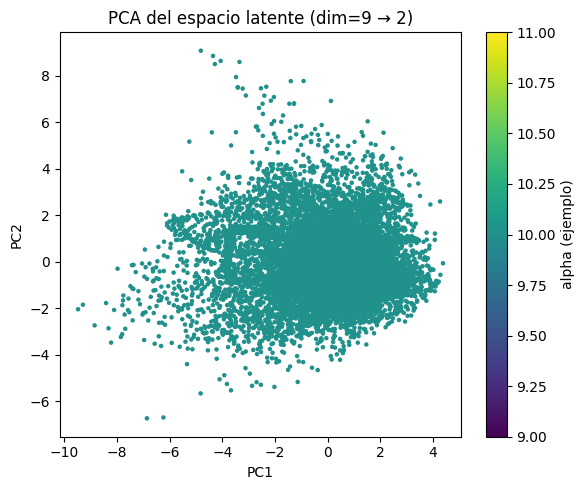

Explained variance ratio (3D): [0.3552971  0.23620234 0.17045325]


In [23]:
import torch
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# 1) Extraer latentes del dataset completo
model.eval()
Z = []
PARAM = []   # opcional: para colorear por un parámetro físico

with torch.no_grad():
    for batch in loader:
        x = batch["input_fields"].to(device)       # (B, 1,256,256,11)
        xr, z = model(x)                           # z: (B, 9)
        Z.append(z.detach().cpu().numpy())

        # opcional: guarda un escalar para color (ej. alpha en índice 0)
        if "constant_scalars" in batch:
            # shape típico: (B, n_scalars). Ajusta el índice según tu dataset
            PARAM.append(batch["constant_scalars"][:, 0].cpu().numpy())

Z = np.concatenate(Z, axis=0)                      # (N, 9)
PARAM = np.concatenate(PARAM, axis=0) if PARAM else None

print("Latent matrix Z shape:", Z.shape)

# 2) (Recomendado) estandarizar latentes antes de PCA
scaler = StandardScaler()
Z_std = scaler.fit_transform(Z)

# 3) PCA a 2 dimensiones (para plot rápido)
pca2 = PCA(n_components=2, random_state=0)
Z2 = pca2.fit_transform(Z_std)
print("Explained variance ratio (2D):", pca2.explained_variance_ratio_)

plt.figure(figsize=(6,5))
if PARAM is not None:
    sc = plt.scatter(Z2[:,0], Z2[:,1], s=5, c=PARAM)  # sin colores fijos
    cbar = plt.colorbar(sc)
    cbar.set_label("alpha (ejemplo)")
else:
    plt.scatter(Z2[:,0], Z2[:,1], s=5)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA del espacio latente (dim=9 → 2)")
plt.tight_layout()
plt.show()

# 4) (Opcional) PCA a 3D
pca3 = PCA(n_components=3, random_state=0)
Z3 = pca3.fit_transform(Z_std)
print("Explained variance ratio (3D):", pca3.explained_variance_ratio_)

# 5) (Opcional) guardar a disco
np.save("latent_Z.npy", Z)            # latentes originales (sin escalar)
np.save("latent_Z_pca2.npy", Z2)      # proyección 2D
if PARAM is not None:
    np.save("latent_param.npy", PARAM)